## Exploring Relationship between Molecular Complexity and IR Spectra
In this IPython Notebook, we analyse the simulated IR and Raman Spectra of molecules to predict the realtionship between IR spectra and complexity of the molecule defined by the molecular assembly. The simulation was performed using xTB based online spectra prediction tool.
https://docs.c6h6.org/docs/eln/uuid/10b6a7229db7dd815afcc75e77c2d6cd/

This notebook requires xtbservice to be present at the appropriate path for importing.

In [1]:
import json
import pathlib
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from xtbservice import xtbservice

#%matplotlib widget
import matplotlib.pyplot as plt
import py3Dmol
from matplotlib import colors
from IPython.display import SVG

rdDepictor.SetPreferCoordGen(True)

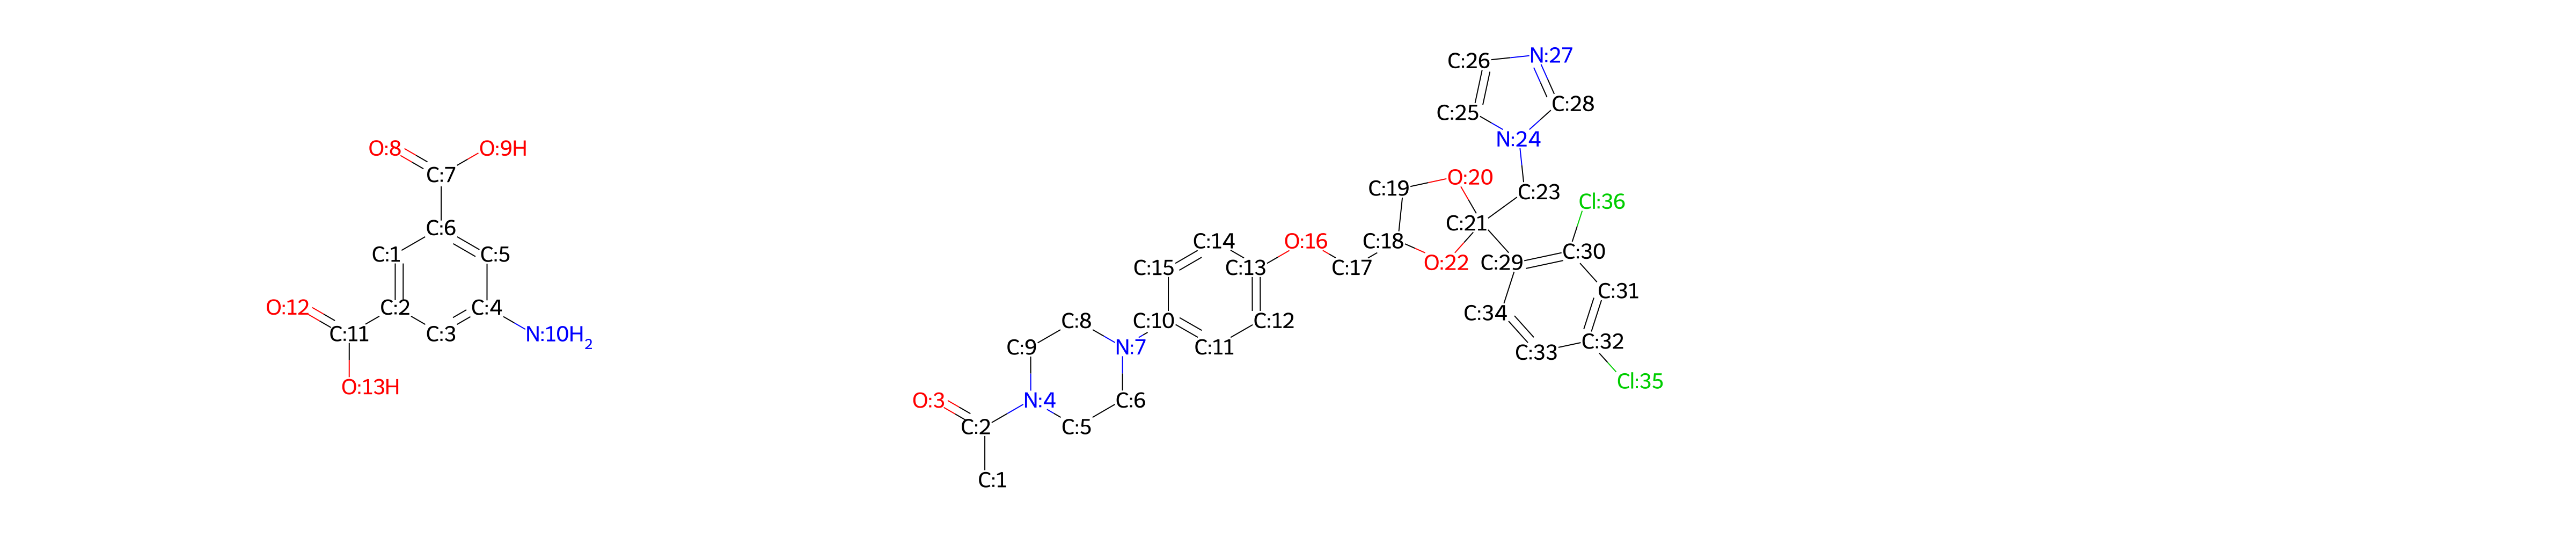

In [2]:
# Timeout has been updated to 100000 for complex molecules (for geometry optimization used in xtbservice)

# Test Molecule 1: 5-Aminoisophthalic acid https://pubchem.ncbi.nlm.nih.gov/compound/5-Aminoisophthalic-acid
# Test_Molecule 2: Ketoconazole https://pubchem.ncbi.nlm.nih.gov/compound/Ketoconazole

test_smiles_1 = 'C1=C(C=C(C=C1C(=O)O)N)C(=O)O'
test_smiles_2 = 'CC(=O)N1CCN(CC1)C2=CC=C(C=C2)OCC3COC(O3)(CN4C=CN=C4)C5=C(C=C(C=C5)Cl)Cl'

test_molecule_1 = Chem.MolFromSmiles(test_smiles_1)
test_molecule_2 = Chem.MolFromSmiles(test_smiles_2)

test_molecule_1H = Chem.AddHs(test_molecule_1)
test_molecule_2H = Chem.AddHs(test_molecule_2)

test_molecule_1.SetProp("_Name", "5-Aminoisophthalic acid")
print(Chem.MolToMolBlock(test_molecule_1), file=open('5-AminoisophthalicAcid.mol','w+'))

test_molecule_2.SetProp("_Name", "Ketoconazole")
print(Chem.MolToMolBlock(test_molecule_2), file=open('Ketoconazole.mol','w+'))

#ir_output1 = xtbservice.ir_from_smiles(test_smiles_1, method='GFN2xTB')
#ir_output2 = xtbservice.ir_from_smiles(test_smiles_2, method='GFN2xTB')

ir_output1 = xtbservice.ir_from_smiles(test_smiles_1, method='GFNFF')
ir_output2 = xtbservice.ir_from_smiles(test_smiles_2, method='GFNFF')

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

Draw.MolsToGridImage((mol_with_atom_index(test_molecule_1), mol_with_atom_index(test_molecule_2)), subImgSize=(1600,1000))

In [3]:
[ir_output1.hasLargeImaginaryFrequency,ir_output2.hasLargeImaginaryFrequency]

[False, False]

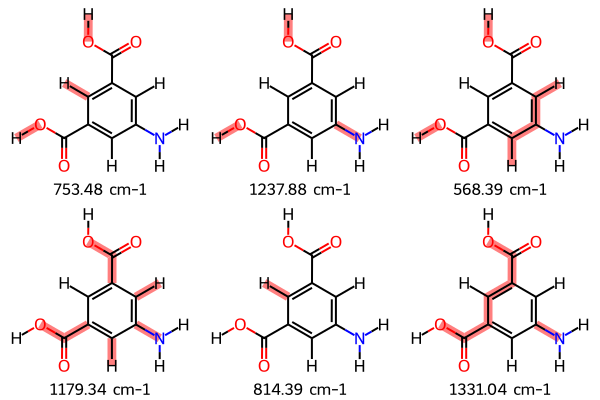

In [4]:
# Getting info of modes in the fingerprint region (looking at top six modes with maximum intensity)
modesList = [mode for mode in ir_output1.modes if mode['imaginary'] is not True and mode['wavenumber'] >= 400 and mode['wavenumber'] <= 1500]
modes_info = np.array([[mode['number'], mode['wavenumber'], mode['intensity']] for mode in modesList])
sorted_modes_info = modes_info[(-1*modes_info[:,2]).argsort()][:6]

selected_modes = sorted_modes_info[:,0].astype(int)
output_modes = [ir_output1.modes[m] for m in selected_modes]

# Visualizing molecules with most contributing bonds with highest intesities in the fingerprint region (top six modes)
highlight_A = [mode['mostContributingAtoms'] for mode in output_modes]
highlightBondList = [mode['mostContributingBonds'] for mode in output_modes]
highlight_B = [[test_molecule_1H.GetBondBetweenAtoms(*bond).GetIdx() for bond in highlightBonds] for highlightBonds in highlightBondList]
wavenumber_list = [str(round(mode['wavenumber'],2)) + ' cm-1' for mode in output_modes]
img = Draw.MolsToGridImage([test_molecule_1H]*len(output_modes), highlightBondLists=highlight_B, legends=wavenumber_list, molsPerRow=3, subImgSize=(200,200), useSVG = True)
img

In [5]:
# Exporting the molecule with vibrational modes for the publication
for i in range(6):
    draw_mol = Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
    draw_mol.drawOptions().setHighlightColour((0.0,1.0,0.0))
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(draw_mol, test_molecule_1H, highlightBonds=highlight_B[i])
    draw_mol.FinishDrawing()
    svg_out = draw_mol.GetDrawingText()
    with open("mode_"+ str(i) +".svg", 'w') as f:
        f.write(svg_out)

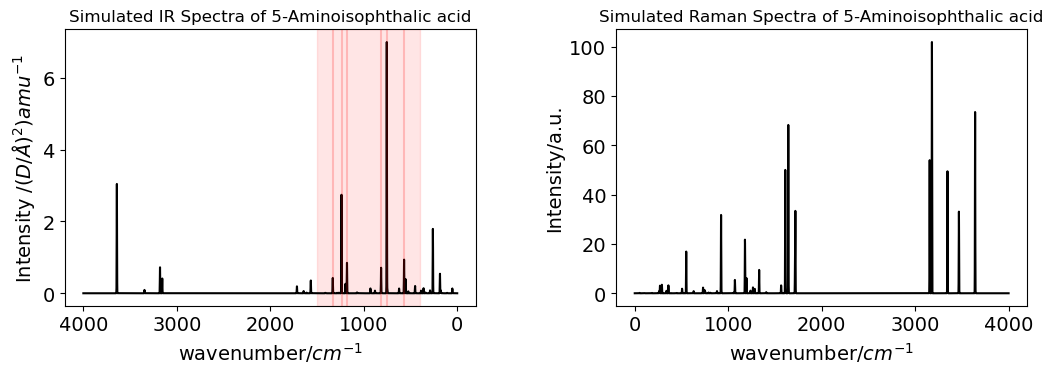

In [6]:
# Fingerprint region range
fp_min, fp_max = 400, 1500

# Plotting IR and Raman Spectra
mol1_wavenumbers, mol1_intensities, mol1_ramanintensities = np.array(ir_output1.wavenumbers), np.array(ir_output1.intensities), np.array(ir_output1.ramanIntensities)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout(pad=7.0)
ax1.plot(mol1_wavenumbers, mol1_intensities, color='k')
ax1.invert_xaxis()
ax1.axvspan(400, 1500, color='red', alpha=0.1)
[ax1.axvline(x=mode['wavenumber'], color='red', alpha=0.2) for mode in output_modes]
ax1.set_xlabel("wavenumber/$cm^{-1}$", fontsize=14)
ax1.set_ylabel("Intensity /$(D/\AA)^2) amu^{-1}$", fontsize=14)
ax1.set_title('Simulated IR Spectra of 5-Aminoisophthalic acid')
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(mol1_wavenumbers, mol1_ramanintensities, color='k')
ax2.set_xlabel("wavenumber/$cm^{-1}$", fontsize=14)
ax2.set_ylabel("Intensity/a.u.", fontsize=14)
ax2.set_title('Simulated Raman Spectra of 5-Aminoisophthalic acid')
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('spectra_2.svg')

In [7]:
# Visualizing the first mode as example: 1133.2 cm-1
xyz = output_modes[0]['displacements']
xyz_view = py3Dmol.view(width=400,height=400)
xyz_view.addModel(xyz,'xyz',{'vibrate': {'frames':30,'amplitude':1.0}})
xyz_view.setStyle({'stick':{}})
xyz_view.setBackgroundColor('0xeeeeee')
xyz_view.animate({'loop': 'backAndForth'})
xyz_view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

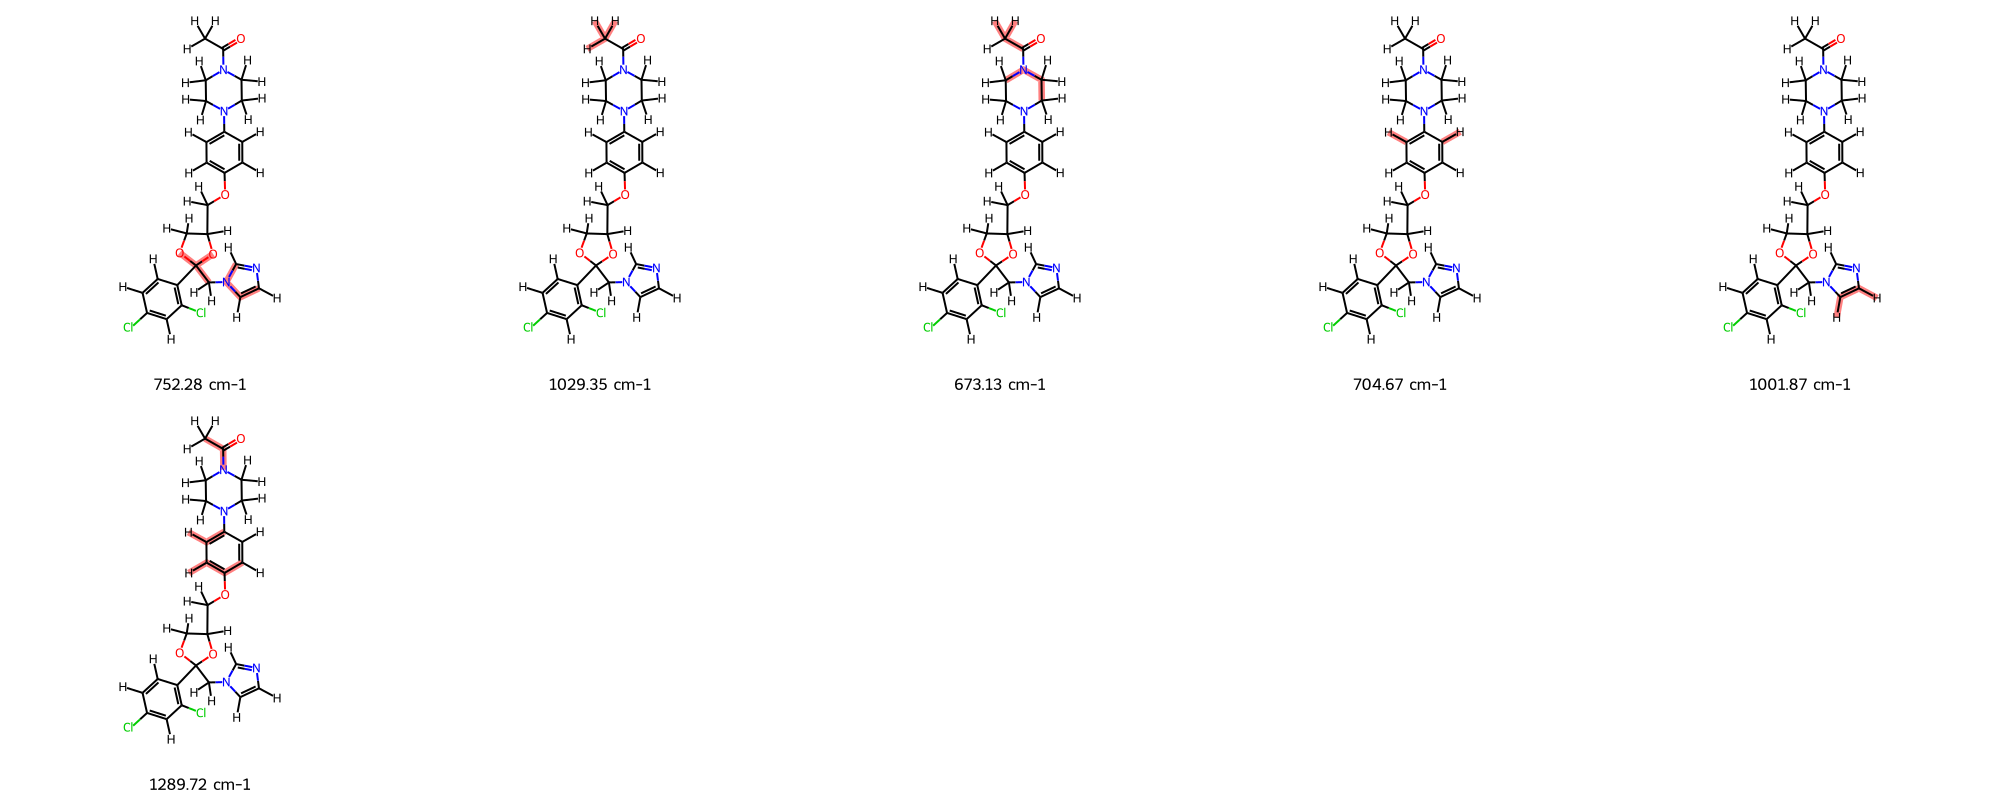

In [8]:
# Getting info of modes in the fingerprint region (looking at top six modes with maximum intensity)
modesList = [mode for mode in ir_output2.modes if mode['imaginary'] is not True and mode['wavenumber'] >= 400 and mode['wavenumber'] <= 1500]
modes_info = np.array([[mode['number'], mode['wavenumber'], mode['intensity']] for mode in modesList])
sorted_modes_info = modes_info[(-1*modes_info[:,2]).argsort()][:6]

selected_modes = sorted_modes_info[:,0].astype(int)
output_modes = [ir_output2.modes[m] for m in selected_modes]

# Visualizing molecules with most contributing bonds with highest intesities in the fingerprint region
highlight_A = [mode['mostContributingAtoms'] for mode in output_modes]
highlightBondList = [mode['mostContributingBonds'] for mode in output_modes]
highlight_B = [[test_molecule_2H.GetBondBetweenAtoms(*bond).GetIdx() for bond in highlightBonds] for highlightBonds in highlightBondList]
wavenumber_list = [str(round(mode['wavenumber'],2)) + ' cm-1' for mode in output_modes]
Draw.MolsToGridImage([test_molecule_2H]*len(output_modes), highlightBondLists=highlight_B, legends=wavenumber_list, molsPerRow=5, subImgSize=(400,400))

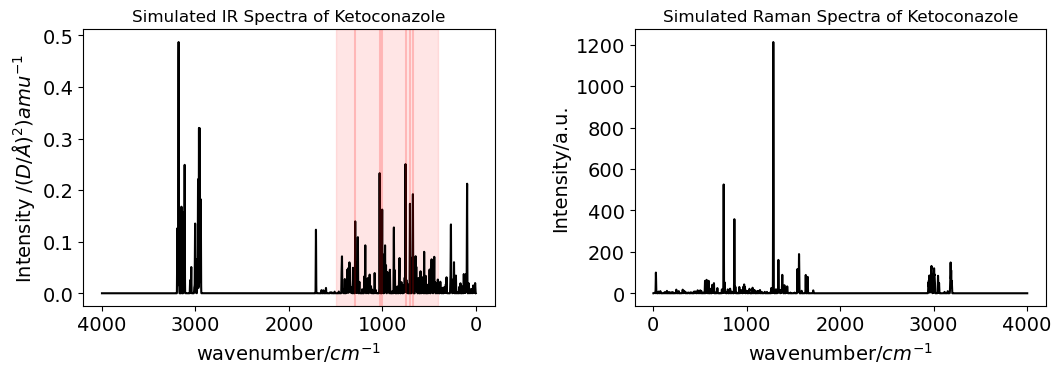

In [9]:
# Fingerprint region range
fp_min, fp_max = 400, 1500

# Plotting IR and Raman Spectra
mol1_wavenumbers, mol1_intensities, mol1_ramanintensities = np.array(ir_output2.wavenumbers), np.array(ir_output2.intensities), np.array(ir_output2.ramanIntensities)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout(pad=7.0)
ax1.plot(mol1_wavenumbers, mol1_intensities, color='k')
ax1.invert_xaxis()
ax1.axvspan(400, 1500, color='red', alpha=0.1)
[ax1.axvline(x=mode['wavenumber'], color='red', alpha=0.2) for mode in output_modes]
ax1.set_xlabel("wavenumber/$cm^{-1}$", fontsize=14)
ax1.set_ylabel("Intensity /$(D/\AA)^2) amu^{-1}$", fontsize=14)
ax1.set_title('Simulated IR Spectra of Ketoconazole')
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(mol1_wavenumbers, mol1_ramanintensities, color='k')
ax2.set_xlabel("wavenumber/$cm^{-1}$", fontsize=14)
ax2.set_ylabel("Intensity/a.u.", fontsize=14)
ax2.set_title('Simulated Raman Spectra of Ketoconazole')
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('spectra_2.svg')

In [10]:
# Visualizing the third mode as example: 1133.2 cm-1
xyz = output_modes[2]['displacements']
xyz_view = py3Dmol.view(width=400,height=400)
xyz_view.addModel(xyz,'xyz',{'vibrate': {'frames':30,'amplitude':1.0}})
xyz_view.setStyle({'stick':{}})
xyz_view.setBackgroundColor('0xeeeeee')
xyz_view.animate({'loop': 'backAndForth'})
xyz_view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol